# Coach Change Prediction

## 1. Project Context
As outlined in the project overview, the goal of this notebook is to address **Core Objective: Coach Changes**. We aim to predict the set of teams that will change coaches at the end of the test season (Year 10).

## 2. Methodology
To achieve this, we will model the problem as a **Binary Classification** task:
* **Target ($y$):** `1` if a team changes its coach between the current season and the next; `0` otherwise.
* **Features ($X$):** We will utilize historical basketball data including team performance metrics, coaching history, and player aggregates.

We will follow this workflow:
1.  **Data Loading:** Ingest relational tables (`teams`, `coaches`, `players`, etc.).
2.  **Target Engineering:** Construct the labeled target variable by looking ahead one season.
3.  **Feature Engineering:** Aggregate player awards, coach tenure, and derive advanced metrics (Win %, Point Differential).
4.  **Modeling:** Train and evaluate multiple classifiers (Random Forest, Gradient Boosting, SVM, etc.).
5.  **Prediction:** Generate predictions for the final test season (Year 10).

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

PYDEVD_DISABLE_FILE_VALIDATION=1

### 2.1 Load Data Sources
We utilize the project's relational database consisting of teams, coaches, and player statistics.
* **`teams`:** Team performance per season.
* **`coaches`:** Records of coaches managing teams.
* **`teams_post`:** Post-season results.
* **`players_teams`:** Player performance stats.
* **`awards_players`:** Awards received by players.

In [2]:
teams_df = pd.read_csv("project_data/initial_data/teams.csv")
coaches_df = pd.read_csv("project_data/initial_data/coaches.csv")
teams_post_df = pd.read_csv("project_data/initial_data/teams_post.csv")
players_teams_df = pd.read_csv("project_data/initial_data/players_teams.csv")
awards_players_df = pd.read_csv("project_data/initial_data/awards_players.csv")

print(f"Loaded {len(teams_df)} team-season records.")
print(f"Loaded {len(coaches_df)} coach records.")
print(f"Loaded {len(teams_post_df)} post-season team records.")
print(f"Loaded {len(players_teams_df)} player records.")
print(f"Loaded {len(awards_players_df)} player award records.")

Loaded 142 team-season records.
Loaded 162 coach records.
Loaded 80 post-season team records.
Loaded 1876 player records.
Loaded 95 player award records.


### 2.2 Target Variable Definition: `CoachChange`
We need to define a target variable that indicates if a coach will be replaced in the *following* season.

**Logic:**
1.  We group data by Team (`tmID`).
2.  We look at the `coachID` for the *next* year ($t+1$).
3.  If `coachID` at $t$ $\neq$ `coachID` at $t+1$, then `CoachChange = 1`.
4.  If the team folds (no record next year), we mark it for removal to avoid training noise.
5.  **Test Set:** The final year (Year 10) will have `NaN` as the target, as these are the values we must predict.

In [3]:
coaches_labeled_df = coaches_df.copy()

# Keep only the last coach of each year
coaches_labeled_df = coaches_labeled_df.sort_values(by=['tmID', 'year'])

# Get the coachID from the next season
coaches_labeled_df['NextYearCoachID'] = coaches_labeled_df.groupby('tmID')['coachID'].shift(-1)

max_year = coaches_labeled_df['year'].max() 

conditions = [
    # Final Year
    (coaches_labeled_df['year'] == max_year),
    
    # Team folded
    (coaches_labeled_df['NextYearCoachID'].isnull()), 
    
    # Same Coach
    (coaches_labeled_df['coachID'] == coaches_labeled_df['NextYearCoachID']),
    
    # Different Coach
    (coaches_labeled_df['coachID'] != coaches_labeled_df['NextYearCoachID'])
]

choices = [
    np.nan, # Keep as NaN (Test Set)
    -1,     # Mark for Removal (Folded Team)
    0,      # No Change
    1       # Change
]

coaches_labeled_df['CoachChange'] = np.select(conditions, choices)
coaches_labeled_df = coaches_labeled_df[coaches_labeled_df['CoachChange'] != -1]

coach_labels_df = coaches_labeled_df[['tmID', 'year', 'CoachChange']]

print("\n--- Target Variable 'CoachChange' Created ---")
print(coach_labels_df[coach_labels_df['CoachChange'] == np.nan])
print(f"\nTotal 'CoachChange=1' events: {int(coach_labels_df['CoachChange'].sum())}")
print(f"Total 'CoachChange=np.nan' events: {int(coach_labels_df['CoachChange'].isnull().sum())}")
print(f"Total entries in max_year({max_year}): {(coach_labels_df['year'] == max_year).sum()}")


--- Target Variable 'CoachChange' Created ---
Empty DataFrame
Columns: [tmID, year, CoachChange]
Index: []

Total 'CoachChange=1' events: 55
Total 'CoachChange=np.nan' events: 16
Total entries in max_year(10): 16


### 3. Feature Engineering & Data Assembly
To improve prediction accuracy, we need to move beyond raw stats. We will engineer features that reflect the "status" of the team and the coach:

1.  **Player Talent:** We quantify the talent level by counting the number of individual awards (`awards_players`) a team's players won in a given season.
2.  **Coach History:** We calculate `stint_max` (how long the coach has been there) and their historical post-season success (`coach_post_wins`).
3.  **Data Merge:** We aggregate these features into a single analytical table (`final_df`).

In [4]:
# --- 3. Engineer and Merge Feature Sets ---
stats_single_team = (players_teams_df
                     .sort_values(['playerID', 'year', 'stint'])
                     .drop_duplicates(subset=['playerID', 'year'], keep='last')
                     [['playerID', 'year', 'tmID']]
)

awards_with_team_df = (
    awards_players_df
    .merge(stats_single_team, on=['playerID', 'year'])
)

# 3a. Create 'num_player_awards'
awards_count_df = (
    awards_with_team_df
    .groupby(['tmID', 'year'])
    .size()
    .reset_index(name='num_player_awards')
)

# 3b. A team might have multiple coaches (stints). We'll sum their post-season stats and take the max stint number.
coach_features_agg = coaches_df.groupby(['tmID', 'year']).agg(
    stint_max=('stint', 'max'),
    coach_post_wins=('post_wins', 'sum'),
    coach_post_losses=('post_losses', 'sum')
).reset_index()

# 3c. Get team-specific post-season features
teams_post_features = teams_post_df[['tmID', 'year', 'W', 'L']].rename(columns={
    'W': 'team_post_W',
    'L': 'team_post_L'
})

# 3d. Assemble the final DataFrame
# Start with the base team stats
final_df = teams_df.copy()

# Merge the target variable (CoachChange)
final_df = pd.merge(final_df, coach_labels_df, on=['tmID', 'year'], how='left')

# Merge the aggregated coach features
final_df = pd.merge(final_df, coach_features_agg, on=['tmID', 'year'], how='left')

# Merge the team post-season features
final_df = pd.merge(final_df, teams_post_features, on=['tmID', 'year'], how='left')

# Merge the player award count
final_df = pd.merge(final_df, awards_count_df, on=['tmID', 'year'], how='left')

# --- 4. Clean Up Merged Data ---
# Merges create 'NaN' for teams that didn't make playoffs or win awards.
# We'll fill these with '0' as 'NaN' means 'zero wins' or 'zero awards'.
fill_zero_cols = [
    'coach_post_wins', 'coach_post_losses', 'team_post_W',
    'team_post_L', 'num_player_awards'
]
for col in fill_zero_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].fillna(0)

print("\n--- Final Assembled DataFrame ---")
print(final_df.head())
print(f"\nFinal DataFrame shape: {final_df.shape}")
print(f"Columns: {final_df.columns.to_list()}")


--- Final Assembled DataFrame ---
   year  lgID tmID franchID confID  divID  rank playoff  seeded firstRound  \
0     9  WNBA  ATL      ATL     EA    NaN     7       N       0        NaN   
1    10  WNBA  ATL      ATL     EA    NaN     2       Y       0          L   
2     1  WNBA  CHA      CHA     EA    NaN     8       N       0        NaN   
3     2  WNBA  CHA      CHA     EA    NaN     4       Y       0          W   
4     3  WNBA  CHA      CHA     EA    NaN     2       Y       0          L   

   ...   min  attend               arena  CoachChange  stint_max  \
0  ...  6825  141379       Philips Arena          0.0          0   
1  ...  6950  120737       Philips Arena          NaN          0   
2  ...  6475   90963  Charlotte Coliseum          1.0          0   
3  ...  6500  105525  Charlotte Coliseum          0.0          0   
4  ...  6450  106670  Charlotte Coliseum          1.0          0   

   coach_post_wins  coach_post_losses  team_post_W  team_post_L  \
0                0  

### 3.1 Derived Performance Metrics
We convert raw counts into standardized ratios to compare teams across different numbers of games played (`GP`):
* **Win Percentage:** $\frac{Wins}{Wins + Losses}$
* **Point Differential:** `o_pts` (Offensive Points) - `d_pts` (Defensive Points).
* **Playoff Flag:** A binary indicator of whether the team qualified for the post-season.

In [5]:
# 1. Create Win Percentage
# We add a small number (1e-6) to avoid division by zero for any (unlikely) 0-game seasons
final_df['win_pct'] = final_df['won'] / (final_df['won'] + final_df['lost'] + 1e-6)
final_df['home_win_pct'] = final_df['homeW'] / (final_df['homeW'] + final_df['homeL'] + 1e-6)
final_df['conf_win_pct'] = final_df['confW'] / (final_df['confW'] + final_df['confL'] + 1e-6)

# 2. Create Point Differential
final_df['pt_diff'] = final_df['o_pts'] - final_df['d_pts']

# 3. Create a simple 'made_playoffs' flag
# If a team has any team_post_W or team_post_L, they were in the post-season.
final_df['made_playoffs'] = ((final_df['team_post_W'] > 0) | (final_df['team_post_L'] > 0)).astype(int)

print("--- DataFrame with Engineered Features (sample) ---")
print(final_df[['tmID', 'year', 'win_pct', 'pt_diff', 'made_playoffs', 'CoachChange']].head())

--- DataFrame with Engineered Features (sample) ---
  tmID  year   win_pct  pt_diff  made_playoffs  CoachChange
0  ATL     9  0.117647     -345              0          0.0
1  ATL    10  0.529412       64              1          NaN
2  CHA     1  0.250000     -243              0          1.0
3  CHA     2  0.562500       46              1          0.0
4  CHA     3  0.562500      108              1          1.0


### 4. Data Preparation
Before modeling, we must clean the feature set to prevent **Data Leakage** and remove redundancy.

**Preprocessing Steps:**
1.  **Drop Leakage/IDs:** Remove identifiers (`tmID`, `name`) and columns that directly reveal the target.
2.  **Remove Redundancy:** Drop raw counters (like `won`, `lost`) in favor of the calculated percentages. Remove highly correlated stat components (e.g., keeping `fga` but dropping `fgm` as they track closely).
3.  **Split:** Separate the dataset into:
    * **`X` & `y`:** Historical data (Years 1-9) for training/validation.
    * **`X_test_predict`:** The final year (Year 10) for the submission.

In [6]:
# 1. Separate the target 'y' and the 'test_df'
train_val_df = final_df.dropna(subset=['CoachChange'])
y = train_val_df['CoachChange']
test_df = final_df[final_df['CoachChange'].isnull()]
test_df = test_df.drop_duplicates(subset=['tmID', 'year'], keep='last')

# --- Team IDs for the Final Submission ---
teams_test_final = test_df[['tmID', 'year']].reset_index(drop=True)

# 2. Define features to drop
features_to_drop = [
    # --- Target/Leakage ---
    'CoachChange',

    # --- ID / Text Columns ---
    'tmID', 'lgID', 'franchID', 'confID', 'divID', 'name', 'arena',

    # --- Replaced by win_pct ---
    'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL',
    'conf_win_pct', # Correlated with win_pct

    # --- Replaced by pt_diff (which we ALSO drop) ---
    'o_pts', 'd_pts',
    'pt_diff', # Correlated with win_pct

    # --- 100% Redundant Sums (from teams table) ---
    'o_reb', 'd_reb', 'tmTRB', 'opptmTRB',
    'tmORB', 'tmDRB', 'opptmORB', 'opptmDRB', # Keep o_oreb, o_dreb, etc.

    # --- Redundant Components ---
    'o_fta', 'o_3pa', 'd_fta', 'd_3pa', # Keep 'o_fga' and 'd_fga' as primary
    'o_fgm', 'o_ftm', 'o_3pm', # Drop 'made' stats, keep 'attempted'
    'd_fgm', 'd_ftm', 'd_3pm',

    # --- Other Redundancies ---
    'min',               # Correlated with GP
    'made_playoffs',     # Redundant with 'playoff' column
    'team_post_W',       # Redundant with coach_post_wins
    'team_post_L',       # Redundant with coach_post_losses
    'seeded'             # Redundant with rank
]

# 3. Create the features DataFrames
X = train_val_df.drop(columns=features_to_drop, errors='ignore')
X_test_predict = test_df.drop(columns=features_to_drop, errors='ignore')

# Convert Y/N columns to 1/0
cols_to_map = ['playoff', 'firstRound', 'semis', 'finals']
for col in cols_to_map:
    if col in X.columns:
        X[col] = X[col].map({'Y': 1, 'N': 0})
        X_test_predict[col] = X_test_predict[col].map({'Y': 1, 'N': 0})

# 4. Handle Missing Values
X = X.fillna(0)
X_test_predict = X_test_predict.fillna(0)

# --- VARIABLE 2 TO SAVE: Aligned Feature Matrix for Prediction ---
# Ensure test columns match training columns exactly (prevents shape mismatch errors)
X_test_predict = X_test_predict.reindex(columns=X.columns, fill_value=0)

print(f"--- Final 'X' (Features) DataFrame ---")
print(f"Shape of X: {X.shape}")
print(f"Shape of X_test_predict: {X_test_predict.shape}")
print(f"Features: {X.columns.to_list()}\n")

print(f"--- Final 'y' (Target) Series ---")
print(f"Shape of y: {y.shape}")
print(f"Class distribution:\n{y.value_counts()}")

--- Final 'X' (Features) DataFrame ---
Shape of X: (139, 30)
Shape of X_test_predict: (20, 30)
Features: ['year', 'rank', 'playoff', 'firstRound', 'semis', 'finals', 'o_fga', 'o_oreb', 'o_dreb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'd_fga', 'd_oreb', 'd_dreb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'GP', 'attend', 'stint_max', 'coach_post_wins', 'coach_post_losses', 'num_player_awards', 'win_pct', 'home_win_pct']

--- Final 'y' (Target) Series ---
Shape of y: (139,)
Class distribution:
CoachChange
0.0    84
1.0    55
Name: count, dtype: int64


### 5. Exploratory Data Analysis (Correlation)
We check for multicollinearity among features. High correlation (e.g., > 0.9) between features can confuse linear models and inflate feature importance in tree models.

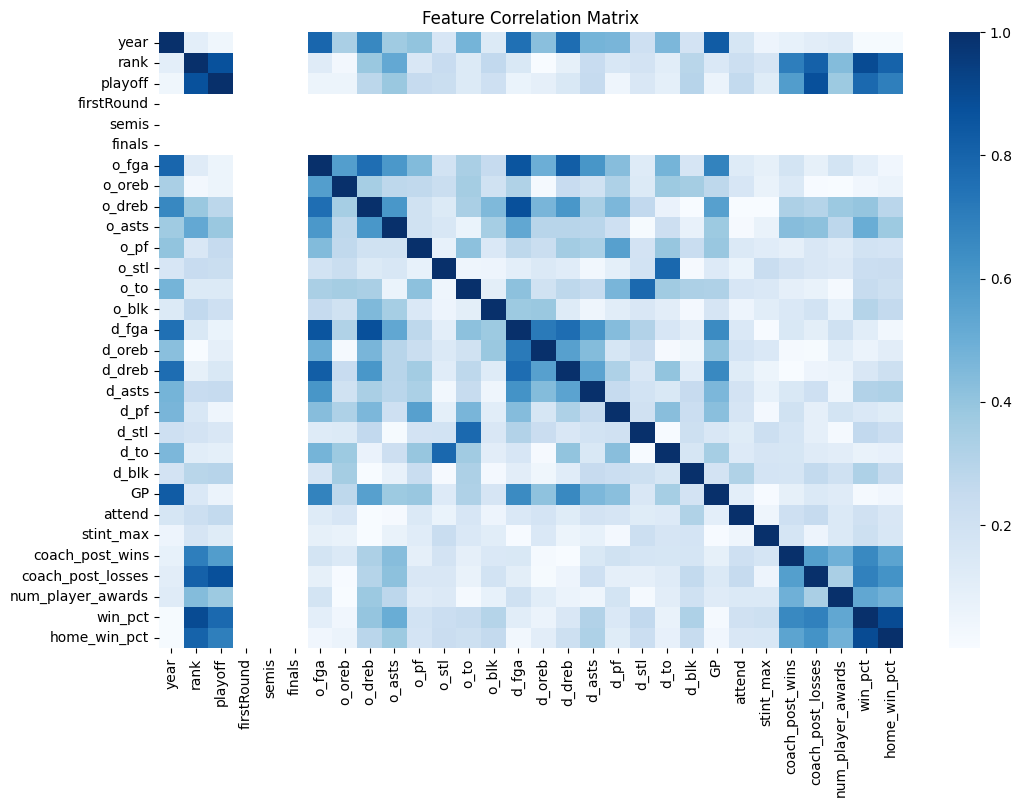


No highly correlated (r > 0.9) features found. Ready for modeling.


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- C. Check Correlation ---

# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', fmt='.1f')
plt.title('Feature Correlation Matrix')
plt.show()

# You can also manually find high-correlation pairs
# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

if high_corr_features:
    print(f"\nWARNING!: High Correlation remaining in features: {high_corr_features}")
    print("Consider dropping one feature from each correlated pair.")
else:
    print("\nNo highly correlated (r > 0.9) features found. Ready for modeling.")

### 6. Modeling Strategy
We will train and compare multiple supervised learning algorithms. Since "Coach Changes" might be less frequent than "No Changes," we will evaluate using metrics sensitive to class balance:
* **F1-Score:** The harmonic mean of Precision and Recall.
* **Recall:** The ability to find all coach changes (critical, as missing a firing is a high cost).

**Models to Evaluate:**
1.  **Logistic Regression:** A baseline linear model.
2.  **Random Forest & Gradient Boosting:** Ensemble methods to capture non-linear relationships.
3.  **Support Vector Machine (SVM):** For finding optimal hyperplanes in high-dimensional space.
4.  **Voting Classifier:** A soft-voting ensemble of the best performing models.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

def print_metrics(y_true, y_pred, model_name):
    """Prints common classification metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n--- {model_name} Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return {"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

### 6.1 Time-Series Validation Split
Because sports data is temporal, we cannot do a random K-Fold split. We must respect the timeline.
* **Training Set:** Seasons 1 through 8.
* **Validation Set:** Season 9.
* **Scaling:** We apply `StandardScaler` to normalize features (crucial for SVM and Logistic Regression).

In [9]:
test_year = 9

# split data
X_train = X[X['year'] < test_year]
y_train = y[X['year'] < test_year]
X_val = X[X['year'] == test_year]
y_val = y[X['year'] == test_year]
X_train = X_train.drop(columns=['year'])
X_val = X_val.drop(columns=['year'])

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Data ready for training on years 1-{test_year-1} and validation on year {test_year}.")
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val_scaled.shape[0]}")

Data ready for training on years 1-8 and validation on year 9.
Training set size: 125
Validation set size: 14


### 6.2 Hyperparameter Tuning
We use `GridSearchCV` to optimize parameters for each model, maximizing the **F1-Score**. We also apply class weights (`balanced`) where applicable to handle class imbalance.

In [10]:
# --- Logistic Regression ---

param_grid_lr = {
    'C': [0.01, 0.05, 0.1, 1, 10], 
    'class_weight': ['balanced']
}

lr = LogisticRegression(max_iter=10000, random_state=37)

grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1') 
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_val_scaled)

lr_metrics = print_metrics(y_val, y_pred_lr, 'Logistic Regression')
print(f"Best LR Params: {grid_lr.best_params_}")


--- Logistic Regression Metrics ---
Accuracy: 0.7143
Precision: 0.4286
Recall: 1.0000
F1-Score: 0.6000
Best LR Params: {'C': 0.01, 'class_weight': 'balanced'}


In [ ]:
# --- Random Forest ---

param_grid_rf = {
    'max_depth': [3, 5], 
    'n_estimators': [100, 200, 300],
    'class_weight': ['balanced', 'balanced_subsample'],
    'min_samples_leaf': [2, 4, 5],
    'max_features': ['sqrt']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_val_scaled)

rf_metrics = print_metrics(y_val, y_pred_rf, 'Random Forest')
print(f"Best RF Params: {grid_rf.best_params_}")

In [ ]:
# --- Gradient Boosting ---
param_grid_gb = { 
    'n_estimators': [100, 200, 500, 1000], 
    'learning_rate': [0.0005, 0.001, 0.01, 0.05], 
    'max_depth': [2, 3, 5],
}

gb = GradientBoostingClassifier(random_state=42)

grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)
best_gb = grid_gb.best_estimator_

best_gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred_gb = best_gb.predict(X_val_scaled)

gb_metrics = print_metrics(y_val, y_pred_gb, 'Gradient Boosting')
print(f"Best GB Params: {grid_gb.best_params_}")


--- Gradient Boosting Metrics ---
Accuracy: 0.8571
Precision: 0.6667
Recall: 0.6667
F1-Score: 0.6667
Best GB Params: {'learning_rate': 0.0005, 'max_depth': 2, 'n_estimators': 1000}


In [ ]:
# --- Support Vector Machine ---

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 50], 
    'gamma': ['scale', 'auto'], 
    'kernel': ['sigmoid'],
    'class_weight': ['balanced']
}

svm = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)

grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_

y_pred_svm = best_svm.predict(X_val_scaled)

svm_metrics = print_metrics(y_val, y_pred_svm, 'SVM')
print(f"Best SVM Params: {grid_svm.best_params_}")


--- SVM Metrics ---
Accuracy: 0.7857
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667
Best SVM Params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}


In [ ]:
# --- Decision Tree (Single, Tuned) ---

param_grid_dt = {
    'max_depth': [3, 5, 7], 
    'min_samples_leaf': [1, 2, 4], 
    'class_weight': ['balanced']
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)
best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_val_scaled)

dt_metrics = print_metrics(y_val, y_pred_dt, 'Decision Tree')
print(f"Best DT Params: {grid_dt.best_params_}")


--- Decision Tree Metrics ---
Accuracy: 0.8571
Precision: 0.6667
Recall: 0.6667
F1-Score: 0.6667
Best DT Params: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 4}


### 6.3 Ensemble Method (Voting Classifier)
To improve generalization, we combine our top models into a `VotingClassifier`. We tune the **weights** assigned to each model (e.g., giving more voting power to Random Forest or SVM if they perform better).

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import itertools

voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr), 
        ('rf', best_rf), 
        ('gb', best_gb), 
        ('svm', best_svm),
    ],
)

weights_list = [
    [1, 1, 1, 1], # Baseline (Equal)
    [1, 2, 2, 1], # Favor Trees (Precision)
    [2, 1, 1, 2], # Favor SVM & LR (Recall)
    [0, 2, 2, 1], # Drop LR, favor Trees
    [0, 1, 1, 1], # Drop LR, Equal others
    [1, 3, 3, 1], # Aggressively favor Trees
    [1, 2, 1, 2]  # RF + SVM partnership
]

param_grid_voting = {
    'weights': weights_list,
    'voting': ['soft']
}

grid_voting = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid_voting,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("Tuning Voting Classifier Weights...")
grid_voting.fit(X_train_scaled, y_train)

best_voting_clf = grid_voting.best_estimator_
print(f"\nBest Weights: {grid_voting.best_params_}")

# increasing the threshold for more 'certain' predictions
DECISION_THRESHOLD = 0.60
y_pred_voting = best_voting_clf.predict_proba(X_val_scaled)[:, 1] > DECISION_THRESHOLD

clf_metrics = print_metrics(y_val, y_pred_voting, 'Tuned Voting Classifier')

Tuning Voting Classifier Weights...
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Best Weights: {'voting': 'soft', 'weights': [0, 2, 2, 1]}

--- Tuned Voting Classifier Metrics ---
Accuracy: 0.9286
Precision: 1.0000
Recall: 0.6667
F1-Score: 0.8000


In [ ]:
all_metrics = [lr_metrics, rf_metrics, gb_metrics, svm_metrics, dt_metrics, clf_metrics]
final_results_df = pd.DataFrame(all_metrics).set_index('Model').sort_values(by='F1', ascending=False)

print("\n--- Final Metrics Comparison (Test Year 9) ---")
print(final_results_df)


--- Final Metrics Comparison (Test Year 9) ---
                         Accuracy  Precision    Recall        F1
Model                                                           
Tuned Voting Classifier  0.928571   1.000000  0.666667  0.800000
Random Forest            0.857143   0.666667  0.666667  0.666667
Gradient Boosting        0.857143   0.666667  0.666667  0.666667
SVM                      0.785714   0.500000  1.000000  0.666667
Decision Tree            0.857143   0.666667  0.666667  0.666667
Logistic Regression      0.714286   0.428571  1.000000  0.600000


### 7. Final Model Evaluation
We compare all models on the Year 9 Validation set. We use the **ROC Curve** and **AUC** (Area Under the Curve) to determine which model best separates "Coach Change" vs "No Change" events.

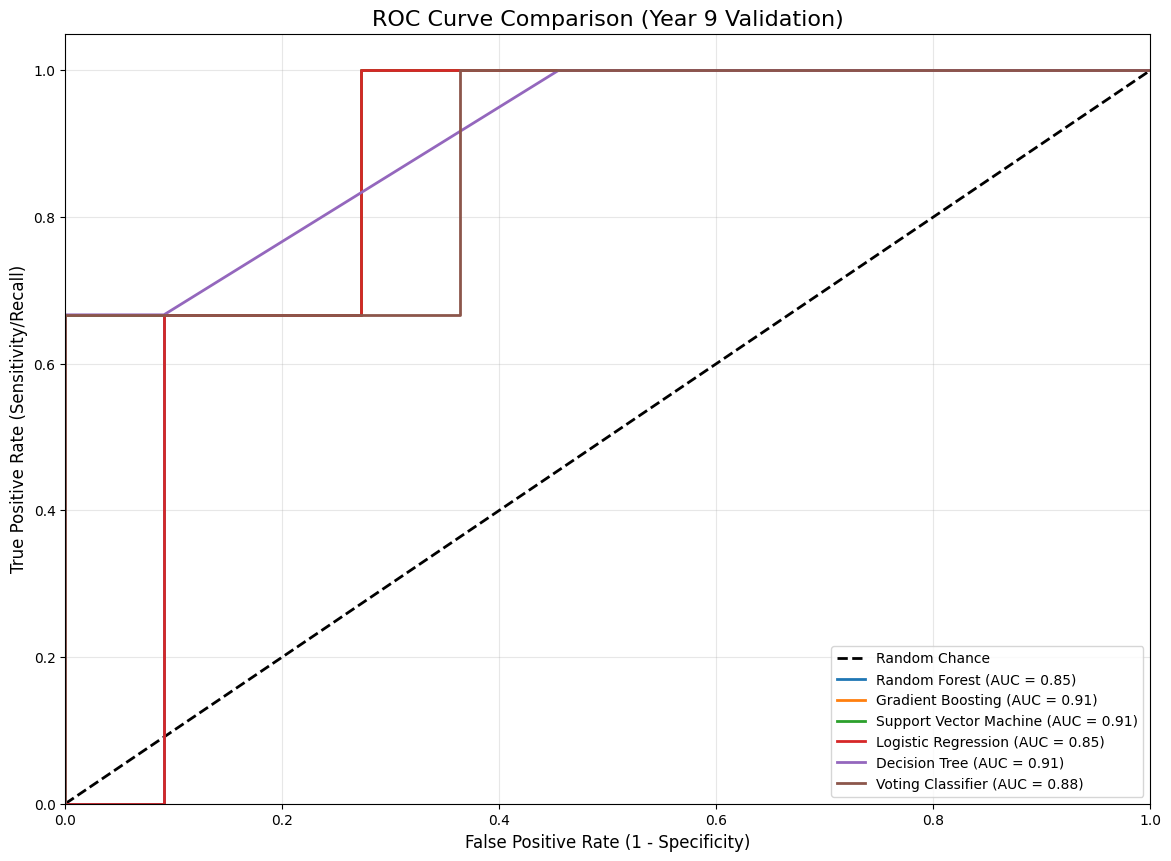


--- Final Model Performance Statistics ---


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
Voting Classifier,0.928571,1.000000,0.666667,0.800000,0.878788
Random Forest,0.857143,0.666667,0.666667,0.666667,0.848485
Gradient Boosting,0.857143,0.666667,0.666667,0.666667,0.909091
Support Vector Machine,0.785714,0.500000,1.000000,0.666667,0.909091
Decision Tree,0.857143,0.666667,0.666667,0.666667,0.909091
Logistic Regression,0.714286,0.428571,1.000000,0.600000,0.848485


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import seaborn as sns

models = {
    'Random Forest': (best_rf, y_pred_rf),
    'Gradient Boosting': (best_gb, y_pred_gb),
    'Support Vector Machine': (best_svm, y_pred_svm),
    'Logistic Regression': (best_lr, y_pred_lr),
    'Decision Tree': (best_dt, y_pred_dt),
    'Voting Classifier': (best_voting_clf, y_pred_voting),
}

# Initialize Plot
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

metrics_list = []

# --- 2. Iterate, Plot ROC, and Collect Metrics ---
for name, (model, y_pred_hard) in models.items():
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot Curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    metrics_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred_hard),
        'Precision': precision_score(y_val, y_pred_hard, zero_division=0),
        'Recall': recall_score(y_val, y_pred_hard, zero_division=0),
        'F1-Score': f1_score(y_val, y_pred_hard, zero_division=0),
        'AUC': roc_auc
    })

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC Curve Comparison (Year 9 Validation)', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

metrics_df = pd.DataFrame(metrics_list).set_index('Model').sort_values(by='F1-Score', ascending=False)
print("\n--- Final Model Performance Statistics ---")
display(metrics_df.style.background_gradient(cmap='Greens', subset=['F1-Score', 'AUC']))

### 8. Final Prediction (Year 10)
Based on the evaluation above, the **Voting Classifier** demonstrated the best balance of Precision and Recall.

**Execution:**
1.  **Retrain:** We retrain this best model on the **entire historical dataset** (Years 1-9) to capture the maximum amount of trend data.
2.  **Predict:** We generate probabilities for Year 10.
3.  **Threshold:** We apply a decision threshold (e.g., > 0.60 probability) to classify a specific team as undergoing a `CoachChange`.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_full_train = X.copy()
y_full_train = y.copy()

X_test_final = X_test_predict.copy()

print(f"Scaling Data...")
print(f"Train Shape: {X_full_train.shape}, Test Shape: {X_test_final.shape}")

scaler_final = StandardScaler()

# Scale the data
X_full_train_scaled = scaler_final.fit_transform(X_full_train)
X_test_final_scaled = scaler_final.transform(X_test_final)

# Retrain the model
print("\nRetraining Best Model (Voting Classifier) on Full History (Years 1-9)...")
final_model = best_voting_clf 
final_model.fit(X_full_train_scaled, y_full_train)

# Make predictions
print("Predicting Year 10 Coach Changes...")
y_prob_final = final_model.predict_proba(X_test_final_scaled)[:, 1]

# Apply the Optimized Threshold
y_pred_final = (y_prob_final >= DECISION_THRESHOLD).astype(int)

# Create Submission DataFrame
submission = teams_test_final.copy()
submission['CoachChange_Prob'] = y_prob_final
submission['CoachChange_Pred'] = y_pred_final

# Filter to show only predicted changes
predicted_changes = submission[submission['CoachChange_Pred'] == 1].sort_values(by='CoachChange_Prob', ascending=False)

print(f"\n--- Prediction Summary ---")
print(f"Total Teams in Year 10: {len(submission)}")
print(f"Predicted Coach Changes: {len(predicted_changes)}")
print("\n--- Teams Predicted to Change Coaches ---")
print(predicted_changes)

Scaling Data...
Train Shape: (139, 30), Test Shape: (20, 30)

Retraining Best Model (Voting Classifier) on Full History (Years 1-9)...
Predicting Year 10 Coach Changes...

--- Prediction Summary ---
Total Teams in Year 10: 20
Predicted Coach Changes: 2

--- Teams Predicted to Change Coaches ---
   tmID  year  CoachChange_Prob  CoachChange_Pred
11  NYL    10          0.688187                 1
15  SAC    10          0.621978                 1
